In [1]:
from osgeo import gdal
label = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm\00a0d9d4_agbm.tif')

In [2]:
data = label.ReadAsArray()

In [3]:
data = data.reshape(1, 256 * 256)

In [4]:
train = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features\00a0d9d4_S2_00.tif')

In [5]:
import numpy as np

In [6]:
traindata = train.ReadAsArray()

In [7]:
# traindata = traindata.reshape(1, 256, 256, 11)
traindata = traindata.reshape(256, 256, 11)

In [8]:
traindata.shape

(256, 256, 11)

In [9]:
traindata

array([[[314, 374, 433, ..., 335, 300, 279],
        [273, 296, 387, ..., 222, 242, 212],
        [212, 183, 198, ..., 178, 172, 182],
        ...,
        [147, 147, 214, ..., 196, 220, 238],
        [249, 244, 208, ..., 230, 248, 279],
        [266, 237, 207, ..., 198, 209, 189]],

       [[256, 252, 183, ..., 171, 183, 186],
        [170, 160, 175, ..., 154, 199, 191],
        [204, 170, 154, ..., 208, 209, 215],
        ...,
        [189, 211, 197, ..., 229, 191, 211],
        [209, 189, 169, ..., 209, 258, 213],
        [225, 244, 204, ..., 205, 200, 192]],

       [[239, 222, 198, ..., 184, 192, 223],
        [123, 129, 184, ..., 173, 190, 143],
        [205, 158, 175, ..., 176, 225, 239],
        ...,
        [337, 326, 300, ..., 357, 363, 428],
        [427, 381, 326, ..., 386, 306, 360],
        [345, 256, 260, ..., 253, 239, 185]],

       ...,

       [[  9,   9,  10, ...,  14,  13,  16],
        [ 13,  13,  14, ...,  21,  19,  19],
        [ 19,  17,  20, ...,  21,  28,  22

In [34]:
import tensorflow as tf

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        # self.input = tf.keras.Input(shape=(224, 224, 12))
        # self.base = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
        #                                               include_top=False,
        #                                               weights='imagenet')
        self.base = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                            weights='imagenet',
                                                            input_shape=(256, 256, 3))
        self.conv = tf.keras.layers.Conv2D(3, 3, padding='same')
        self.flat1 = tf.keras.layers.GlobalAveragePooling2D()
        self.dens3 = tf.keras.layers.Dense(256, activation='relu')
        self.out = tf.keras.layers.Dense(256 * 256, activation='linear')


    def call(self, x, **kwargs):
        # x = self.input(x)
        x = self.conv(x)
        x = self.base(x)
        x = self.flat1(x)
        x = self.dens3(x)
        x = self.out(x)
        return x

    def build_graph(self):
        x = tf.keras.Input(shape=(11, 256, 256, 11))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model = CNN()

In [35]:
model = model.build_graph()

ValueError: Exception encountered when calling layer "resnet50" (type Functional).

Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 11, 256, 256, 3)

Call arguments received by layer "resnet50" (type Functional):
  • inputs=tf.Tensor(shape=(None, 11, 256, 256, 3), dtype=float32)
  • training=False
  • mask=None

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 11)]    0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       300       
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 65536)             16842752  
                                                           

In [33]:
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])

In [14]:
model.fit(x=traindata, y=data, epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 256
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [42]:
traindata.shape

(256, 256, 11)

In [114]:
predict = model.predict(traindata)

1/1 [==============================] - 2s 2s/step


In [115]:
predict

array([[ 37.65966 ,  37.703026,  19.453072, ..., 111.62623 , 111.691124,
         69.23678 ]], dtype=float32)

In [116]:
target_shape = (len(predict), 256, 256)
predictions = predict.reshape(target_shape)

In [117]:
predictions

array([[[ 3.76596603e+01,  3.77030258e+01,  1.94530716e+01, ...,
          1.01626649e-01, -2.13438105e-02,  8.46977901e+00],
        [ 2.68888321e+01,  2.69159145e+01,  1.94206581e+01, ...,
          1.33927393e+01,  1.32792673e+01,  4.28766012e-02],
        [ 7.75278244e+01,  7.74574432e+01,  1.89138794e+01, ...,
          1.09861824e+02,  1.09852989e+02,  1.12787743e+02],
        ...,
        [ 8.11489639e+01,  8.15048523e+01,  6.97966232e+01, ...,
          1.95308437e+01,  1.95211411e+01,  1.75597019e+01],
        [ 8.14803619e+01,  8.14298859e+01,  6.97915115e+01, ...,
          1.95236950e+01,  1.95611744e+01,  1.75840740e+01],
        [ 9.02387314e+01,  9.03320236e+01,  8.05577316e+01, ...,
          1.11626228e+02,  1.11691124e+02,  6.92367783e+01]]],
      dtype=float32)

In [118]:
predictions.shape

(1, 256, 256)

In [119]:
import matplotlib.pyplot as plt

TypeError: Invalid shape (1, 256, 256) for image data

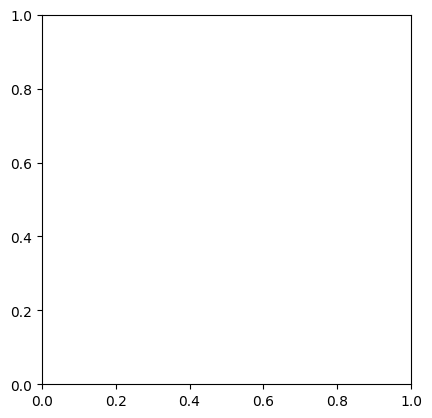

In [120]:
plt.imshow(predictions)

In [121]:
predictions = predictions.flatten()

In [122]:
label = predictions.reshape((256, 256))

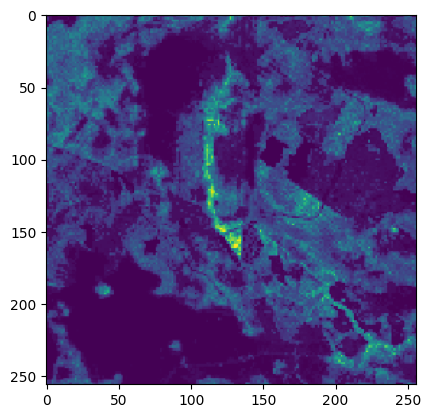

In [123]:
plt.imshow(label)

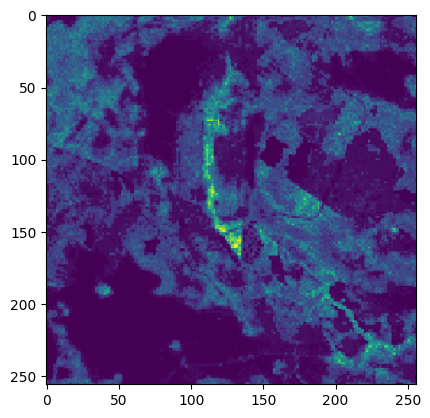

In [124]:
real = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm\00a0d9d4_agbm.tif')
real = real.ReadAsArray()

plt.imshow(real)

In [125]:
test = gdal.Open(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features\00a0d9d4_S2_07.tif')
test = test.ReadAsArray()

In [128]:
test

array([[[2267, 3316, 5861, ..., 6466, 8600, 9035],
        [2336, 2081, 4071, ..., 3767, 6055, 7540],
        [2358, 1975, 3422, ..., 1880, 3236, 3893],
        ...,
        [2774, 4584, 5390, ..., 7795, 8148, 8510],
        [2453, 2437, 2770, ..., 5092, 6841, 6774],
        [1780, 2077, 2394, ..., 2237, 3939, 4760]],

       [[2700, 3450, 6397, ..., 6498, 8578, 8892],
        [2818, 2644, 4627, ..., 3914, 6436, 7706],
        [2769, 2323, 3805, ..., 2337, 3850, 3982],
        ...,
        [3099, 4715, 5270, ..., 7683, 8133, 8455],
        [2824, 3210, 3101, ..., 5537, 7020, 6902],
        [1990, 2283, 2856, ..., 2451, 4240, 4816]],

       [[2585, 3644, 5907, ..., 6332, 8530, 9027],
        [2645, 2399, 4638, ..., 3964, 6241, 7368],
        [2763, 2372, 4042, ..., 2446, 3726, 3869],
        ...,
        [3284, 4442, 5180, ..., 7842, 8168, 8114],
        [2645, 3197, 3227, ..., 5304, 6618, 6721],
        [2230, 2291, 2862, ..., 2560, 4144, 4893]],

       ...,

       [[ 728,  728,  82

In [129]:
test.shape

(11, 256, 256)

In [133]:
test = test.reshape(1, 256, 256, 11)

In [134]:
test.shape


(1, 256, 256, 11)

In [135]:
one = model.predict(test)

1/1 [==============================] - 0s 160ms/step


In [136]:
target_shape = (len(predict), 256, 256)
predictions = predict.reshape(target_shape)
predictions = predictions.flatten()
label = predictions.reshape((256, 256))

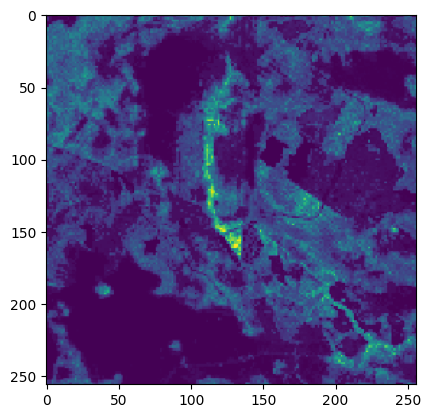

In [137]:
plt.imshow(label)

In [15]:
import os
import os.path as osp
import csv
import data

In [36]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, patch_ids, batch_size=1):
        """
        Few things to mention:
            - The data generator tells our model how to fetch one batch of training data (in this case from files)
            - Any work that can be done before training, should be done in init, since we want fetching a batch to be fast
            - Therefore, we want all filenames and labels to be determined before training
            - This saves work, because we will be fetching batches multiple times (across epochs)
        """
        self.train_dir_path = r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features/'
        self.label_dir = r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_agbm/'
        # Get all filenames in directory
        self.patches = patch_ids

        # Include batch size as attribute
        self.batch_size = batch_size

    def __len__(self):
        """
        Should return the number of BATCHES the generator can retrieve (partial batch at end counts as well)
        """
        return int(np.ceil(len(self.patches) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Tells generator how to retrieve BATCH idx
        """

        # Get filenames for X batch
        batch_patches = self.patches[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = [self.label_dir + p + '_agbm.tif' for p in batch_patches]
        # batch_filenames = [self.train_dir_path + p + f'_S2_{month}.tif' for p in batch_patches for month in range(12)]
        batch_filenames = [osp.join(self.train_dir_path, file) for file in os.listdir(self.train_dir_path) for p in batch_patches if f'{p}_S2' in file]
        # print(batch_filenames)

        batch_x = []
        batch_y = []
        for label_tif in batch_labels:
            label = gdal.Open(label_tif)
            label = label.ReadAsArray()
            label = label.reshape(256 * 256)
            batch_y.append(label)

        #For batch in patches moet hier nog bij
        for s2_tif in batch_filenames:
            batch_per_patch = []
            for p in batch_patches:
                if p in s2_tif:
                    s2 = gdal.Open(s2_tif)
                    s2 = s2.ReadAsArray()
                    s2 = s2.reshape(256, 256, 11)
                    batch_per_patch.append(s2)
            batch_x.append(batch_per_patch)

        return np.asarray(batch_x), np.asarray(batch_y)

In [17]:
with open(osp.join(osp.dirname(data.__file__), 'patch_name_test'), newline='') as f:
    reader = csv.reader(f)
    patch_name_data = list(reader)
patch_names = patch_name_data[0]

In [18]:
patch_names

['00a0d9d4', '00a0fcf3', '000aa810', '000d7e33']

In [37]:
datagen = DataGenerator(patch_names)

In [38]:
x, y = datagen[0]
x

array([[[[[ 314,  374,  433, ...,  335,  300,  279],
          [ 273,  296,  387, ...,  222,  242,  212],
          [ 212,  183,  198, ...,  178,  172,  182],
          ...,
          [ 147,  147,  214, ...,  196,  220,  238],
          [ 249,  244,  208, ...,  230,  248,  279],
          [ 266,  237,  207, ...,  198,  209,  189]],

         [[ 256,  252,  183, ...,  171,  183,  186],
          [ 170,  160,  175, ...,  154,  199,  191],
          [ 204,  170,  154, ...,  208,  209,  215],
          ...,
          [ 189,  211,  197, ...,  229,  191,  211],
          [ 209,  189,  169, ...,  209,  258,  213],
          [ 225,  244,  204, ...,  205,  200,  192]],

         [[ 239,  222,  198, ...,  184,  192,  223],
          [ 123,  129,  184, ...,  173,  190,  143],
          [ 205,  158,  175, ...,  176,  225,  239],
          ...,
          [ 337,  326,  300, ...,  357,  363,  428],
          [ 427,  381,  326, ...,  386,  306,  360],
          [ 345,  256,  260, ...,  253,  239,  185

In [39]:
y.shape

(1, 65536)

In [40]:
for file in os.listdir(r'C:\Users\kuipe\OneDrive\Bureaublad\Epoch\forestbiomass\data\train_features/'):
    if file.startswith("00a0d9d4_S2"):
        print(file)

00a0d9d4_S2_00.tif
00a0d9d4_S2_01.tif
00a0d9d4_S2_02.tif
00a0d9d4_S2_04.tif
00a0d9d4_S2_05.tif
00a0d9d4_S2_06.tif
00a0d9d4_S2_07.tif
00a0d9d4_S2_08.tif
00a0d9d4_S2_09.tif
00a0d9d4_S2_10.tif
00a0d9d4_S2_11.tif


In [41]:
x.shape

(11, 1, 256, 256, 11)

In [25]:
x = x.reshape(1, 11, 256, 256, 11)

In [27]:
x.shape

(1, 11, 256, 256, 11)

In [ ]:
average = np.average